# data import

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
#import s3fs
import io
import scikitplot as skplt


sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [2]:
df_combined = pd.read_csv('data/exported/df_combined.csv', index_col = 0)
df_not_combined = pd.read_csv('data/exported/df_not_combined.csv', index_col = 0)
#df_yeast_not_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_not_combined.csv']), index_col = 0)
#df_yeast_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_combined.csv']), index_col = 0)

# modelling packages

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [4]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [5]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_combined = df_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [6]:
seed = 7

## train test split

In [9]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [10]:
# prepare whole dataframe subsets according to train test split

df_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
df_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
df_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
df_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]

In [205]:
# function to get dataframe into x and y array with format (reads, ref_pos, features) to be able use ref_pos
# as time step in rnn

def prepare_rnn_data (df):
     
    # dummify base sequence and concatenate into temp dataframe with numeric values from source dataframe
    
    df_dum = pd.get_dummies(df[["base_1","base_2","base_3","base_4","base_5"]])
    df_dum = pd.concat([df, df_dum], axis = 1)
    df_dum = df_dum.drop(["base_1","base_2","base_3","base_4","base_5"], axis = 1)
    
    df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]
    
    # feature 3d array:
    # nested for loop over file name, ref_num and read_num to iterate over every unique possible read and concatenate
    # x and y values into a list of lists
    
    X = []
    y= []
    
    for file_name in df_dum.file_name.unique():
        msk1 = df_dum[df_dum.file_name == file_name]
        for ref_num in msk1.ref_number.unique():
            msk2 = msk1[msk1.ref_number == ref_num]
            for read_num in msk2.read_num.unique():
                msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
                X.append(df_dum_num[msk3])
                y.append(df_dum[msk3].modified_status.astype(int))
  
    #stack resulting lists into a 3d numpy array
    
    X = np.stack(X)
    y = np.stack(y)
    
    return X, y

In [214]:
# prepare each dataframe combination with function

X_3d_train, y_3d_train = prepare_rnn_data(df_train_not_combined)
X_3d_test, y_3d_test = prepare_rnn_data(df_test_not_combined)
X_3d_finaltest, y_3d_finaltest = prepare_rnn_data(df_finaltest_not_combined)
X_3d_val, y_3d_val = prepare_rnn_data(df_val_not_combined)

# rnn

In [215]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [216]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [217]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [218]:
# compute class weights

class_weight_list = compute_class_weight("balanced", df_train_not_combined.modified_status.unique(), 
                                         df_train_not_combined.modified_status)
class_weight = dict(zip([1,0], class_weight_list))
class_weight

{1: 15.473684210526315, 0: 0.5166959578207382}

In [219]:
# rnn function (not final)

def rnn(X,y, model):

    VALIDATION_SPLIT = 0.2
    FEATURES = X.shape[2]
    N_TRAIN = len(X) * (1-VALIDATION_SPLIT)
    BUFFER_SIZE = len(X)
    BATCH_SIZE = 20
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    METRICS = ["sparse_categorical_accuracy"]
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=STEPS_PER_EPOCH*1000,
      decay_rate=1,
      staircase=False)
    
    def get_callbacks(name):
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200),
        ]

    def get_optimizer():
        return tf.keras.optimizers.Adam(lr_schedule)
    
    optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.losses.BinaryCrossentropy(
                          from_logits=True, name='binary_crossentropy')],
                 )

    model.summary()


    history = model.fit(
        x=X,
        y=y,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=10000,
        #validation_data=(X_3d_val, y_3d_val),
        callbacks=get_callbacks("tiny model"),
        verbose=0,
        workers = 8,
        class_weight = class_weight,
        use_multiprocessing = True,
        shuffle=True,
        validation_split=VALIDATION_SPLIT
    )
    
    return history

In [226]:
# rnn model

first_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.LSTM(64,return_sequences=True),
    #tf.keras.layers.LSTM(64,return_sequences=False),
    #tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(196, activation ='sigmoid'),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_history["blub"] = rnn(X_3d_train, y_3d_train, first_model)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 196, 64)           23296     
_________________________________________________________________
dropout_5 (Dropout)          (None, 196, 64)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 196, 64)           33024     
_________________________________________________________________
dense_22 (Dense)             (None, 196, 1)            65        
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch: 0, binary_crossentropy:0.2351,  loss:1.8062,  val_binary_crossentropy:0.0432,  val_loss:0.0223,  
..

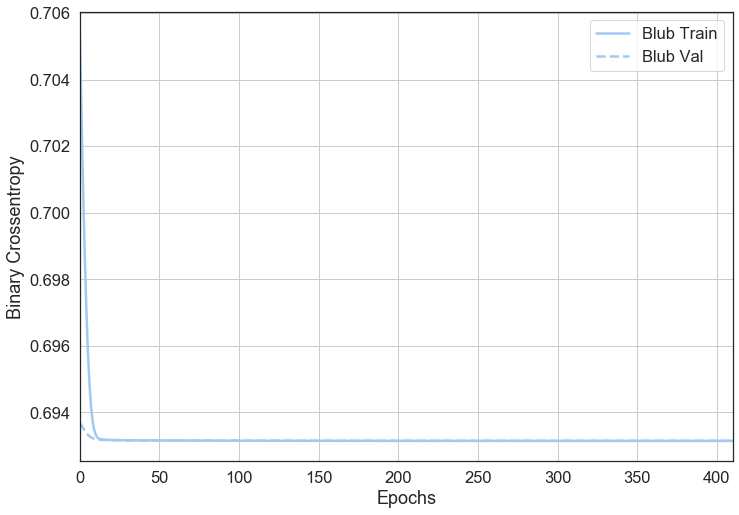

In [179]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(model_history)

In [183]:
y_pred = first_model.predict_classes(X_3d_train)

In [181]:
np.max(y_pred)

4.1543367e-06

In [111]:
cum_res = []
for a in range(y_pred.shape[0]):
    y_trans = []
    y_trans = [0 if i <= 0.5 else 1 for i in y_pred[a]]
    #print(y_trans)
    cum_res.append(y_trans)

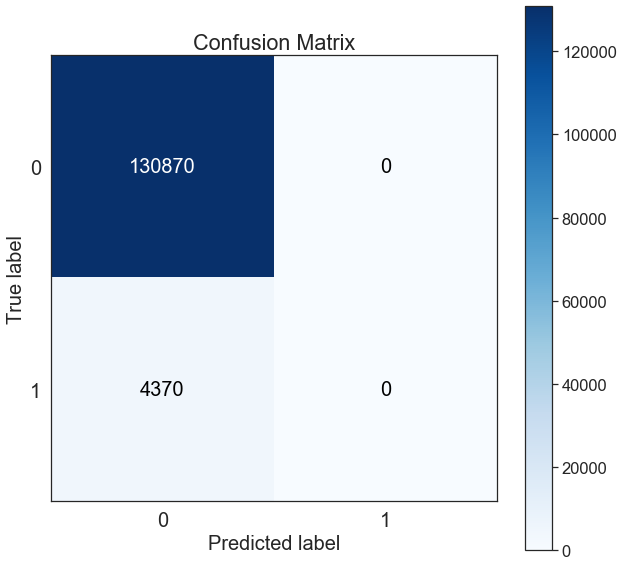

In [184]:
skplt.metrics.plot_confusion_matrix(y_3d_train.flatten(),y_pred.flatten(), figsize=(10,10), text_fontsize=20)

In [56]:
print(classification_report(y_3d_test[0],cum_res[0]))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       182
         1.0       0.09      0.07      0.08        14

    accuracy                           0.88       196
   macro avg       0.51      0.51      0.51       196
weighted avg       0.87      0.88      0.88       196

